<a href="https://colab.research.google.com/github/sanjeevrs2000/CS6910-Assignment/blob/main/Assignment_1_deep_learning_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Deep Learning Assignment 1 - Fashion MNIST dataset**

#**Libraries**

In [2]:
!pip install wandb
!pip install scikit-plot

     |████████████████████████████████| 2.0MB 5.2MB/s 
     |████████████████████████████████| 102kB 7.6MB/s 
     |████████████████████████████████| 163kB 20.8MB/s 
     |████████████████████████████████| 133kB 20.8MB/s 
     |████████████████████████████████| 71kB 6.0MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=1058414051a66363702be2b5d2948b22e0e51da6777fe69712c2c848268830d7
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=2d754b2c57f68323b639ba29cdef77e619ea63c3ea26501ad1d2f218bbd6f6a7
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


In [3]:
import numpy as np
import pandas as pd
import keras
import math
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
import wandb
#import tensorflow as tf
#import tensorflow_datasets as tdfs
from sklearn.metrics import accuracy_score
import scikitplot as skplt
from sklearn.metrics import confusion_matrix

**Visualizing Dataset**

4423680/4422102 [==============================] - 0s 0us/step


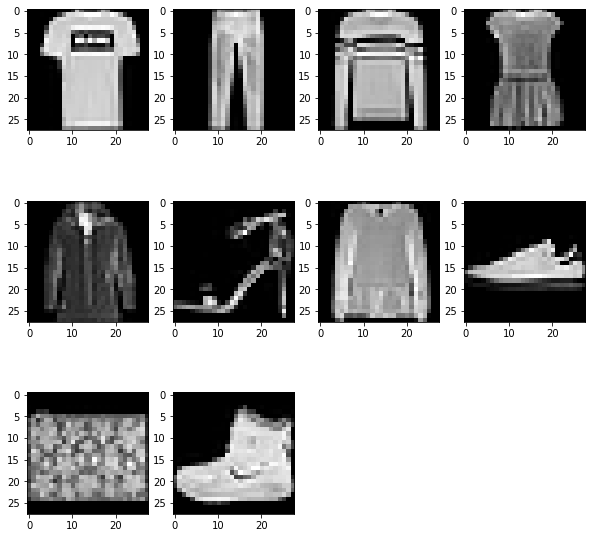

In [4]:
# getting one sample image from each class and visualizing 
(trainx, trainy), (testx, testy)= fashion_mnist.load_data()
classes = np.unique(trainy)
index_mat = [0]*10
for i in classes:
  index_mat[i] = trainy.tolist().index(i)

plt.figure(figsize=(10,10))

for j, i in enumerate(index_mat):
  plt.subplot(3,4,j+1)
  plt.imshow(trainx[i], cmap=plt.get_cmap('gray'))
  
plt.show()

In [5]:
#display images with names in wandb 
#uncomment the following lines logging images in wandb
#wandb.init(entity='sanjeevrs',project='assignment1')
    
#wandb.log({'sample':[wandb.Image(trainx[i],caption=class_names[trainy[i]]) for i in index_mat]})

In [6]:
class_names=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

#normalising input x

x_train = trainx.reshape(60000,784)/255.0
x_test=testx.reshape(10000,784)/255.0
y_test=testy
#one hot encoding y train
temp = np.zeros((60000,10))
temp[np.arange(60000),trainy] = 1
y_train=temp

**Define hyperparameters**

In [7]:
# hyperparameters to be used for training
#the following values give best accuracy on validiation set
#for testing these values without running wandb 
config_defaults = {
        'epochs': 10,
        'batch_size':32,
        'hidden_layers':3,
        'eta': 0.001,
        'size':32,
        'activation': 'sigmoid',      #available: sigmoid,tanh,relu
        'optimizer': 'rmsprop',       # available : sgd,momnetum,rmsprop,nesterov,adam,adagrad
        'wt_decay':0.05,
        'wt_init':'xavier'
        }

config=config_defaults  

In [8]:
#hyperparameters config used for wandb sweep using grid search
sweep_config = {
  'name': 'sweep6',  
  'method': 'grid',
  'parameters': {
        'epochs': {
            'values': [5]
        },
        'batch_size':{
            'values':[32]
        },
        'hidden_layers':{
            'values':[3,4]
        },
        'eta': {
            'values': [0.005]
        },
        'size':{
            'values':[32,64]
        },
        'optimizer': {
            'values': ['adam','rmsprop']
        },
        'activation': {
            'values': ['sigmoid','tanh','relu']
        },
        'wt_decay': {
            'values': [0.005,0.05]
        },
        'wt_init':{
            'values':['xavier','random']
        }
    }
}

**Activation function definitions**

In [9]:
#Defining activation functions and their derivatives

def sigmoid(x):
  return 1/(1+np.exp(-x))

def tanh(x):
  return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

def relu(x):
  t=np.array((np.maximum(0,x)),dtype=np.longdouble)
  return t

def grad_tanh(x):
  return 1-(tanh(x))**2

def grad_relu(x):
  t = np.where(x < 0, 0, x)
  return t

def grad_sigmoid(x):
  return (sigmoid(x)*(1-sigmoid(x)))

def softmax(x):
  exps = np.exp(x )
  return exps / np.sum(exps)

#**Training the model**

In [10]:
def Train():            #define inputs
  
  X = x_train[:50000]
  Y = y_train[:50000]

  x_val = x_train[50000:]
  y_val = y_train[50000:]
  
  #Uncomment the following lines while running wandb

  #wandb.init(config=config_defaults)
  #config = wandb.config
  #wandb.run.name =config['activation']+'config['wt_init]'+'_eta_'+str(config['eta'])+'_hl_'+str(config['hidden_layers'])+'hl_size_'+str(config['size'])

  #get inputs from config
  eta = config['eta']
  epochs = config['epochs']
  batch_size=config['batch_size']
  activation=config['activation']
  optimization=config['optimizer']
  num_hidden_layers = config['hidden_layers'] 
  size=config['size']        
  wt_decay=config['wt_decay']   
  initialization=config['wt_init']
  input_layer_size = 784  #input number of inputs here

  output_layer_size = 10  #input number of output nodes here

  num_nodes = [input_layer_size]

  for i in range(num_hidden_layers):
    num_nodes.append(size)
  num_nodes.append(output_layer_size)

  num_weight_mat = num_hidden_layers+1


  def init_random():
    weights={}
    bias = {}
    for i in  range(1,num_weight_mat+1):
      weights['W%s'% i] = np.random.randn(int(num_nodes[i]),int(num_nodes[i-1]))
      bias['b%s'% i] = np.random.randn(int(num_nodes[i]))
    
    return weights, bias

  def init_xavier():
    weights={}
    bias = {}
    for i in  range(1,num_weight_mat+1):
      weights['W%s'%i] = np.random.normal(0, math.sqrt(1/num_nodes[i-1]) ,size=([int(num_nodes[i]),int(num_nodes[i-1])]))
      bias['b%s'%i] = np.zeros(int(num_nodes[i]))
    
    return weights, bias

  def init_zeros():
    weights={}
    bias = {}
    for i in  range(1,num_weight_mat+1):
      weights['W%s'% i] = np.zeros([int(num_nodes[i]),int(num_nodes[i-1])])
      bias['b%s'% i] = np.zeros(int(num_nodes[i]))

    return weights,bias
  
  
  #Setting weight initialization function
  if initialization == 'random':
    wt_init=init_random()
  elif initialization == 'xavier':
    wt_init = init_xavier()
  else:
    print('weight initialization given is not available')

  #Setting weights
  weights = {}
  bias = {}
  weights, bias = wt_init


  #Setting activation function and its derivative
  if activation == 'sigmoid':
    activ = sigmoid
    der_activ = grad_sigmoid
  elif activation == 'tanh':
    activ = tanh
    der_activ = grad_tanh
  elif activation == 'relu':
    activ = relu
    der_activ = grad_relu

  #Setting output function
  output = softmax 
  activation = activ
  
  #Forward prop
  def forward_prop(weights, bias, x):
    Acti = {}
    H = {}
    
    H['H0'] = x
    
    for i in range(1,num_hidden_layers+1):
      Acti[('A%s'% i)] = np.matmul(weights['W%s'% i],H[('H%s'% (i-1))])+bias['b%s'% i]
      H['H%s'% i] = activation(Acti['A%s'% i])
    
    Acti['A%s'%(num_hidden_layers+1)]= np.matmul(weights['W%s'% (num_hidden_layers+1)],H['H%s'% (num_hidden_layers)])+bias['b%s'% (num_hidden_layers+1)]
    y_hat = output(Acti['A%s'% (num_hidden_layers+1)])  
    
    return y_hat, Acti, H
  

  #Backward prop
  def back_prop(w, b, x, y):
    grad_A = {}
    grad_W = {}
    grad_b = {}
    grad_H = {}  

    y_hat, A, H = forward_prop(w, b, x)

    grad_A['A%s'% (num_hidden_layers+1)] = -(y-y_hat)  #cross entropy loss
    
    #comment the previous line and uncomment the next 2 lines for squared error loss 
    #l = np.argmax(y)                                              #   
    #grad_A['A%s'% (num_hidden_layers+1)] = -y_hat[l]*(y-y_hat)**2 #squared error loss

    for i in range(num_hidden_layers+1, 1, -1):
      
      grad_W['W%s'%i] = np.matmul(grad_A['A%s'%i].reshape(-1,1), H['H%s'%(i-1)].reshape(1,-1))

      grad_b['b%s'%i] = grad_A['A%s'%i]

      grad_H['H%s'%(i-1)] = np.dot(np.transpose(w['W%s'%i]), grad_A['A%s'%i]) 

      grad_A['A%s'%(i-1)] = np.multiply(grad_H['H%s'%(i-1)], der_activ(A['A%s'%(i-1)]))

    grad_W['W1'] = np.multiply(grad_A['A1'].reshape(-1,1), H['H0'].reshape(1,-1))

    grad_b['b1'] = grad_A['A1']

    return grad_W, grad_b
    

   #defining function for sgd optimizer
  def sgd():

    for k in range(epochs):
      for x,y in zip(X,Y):
        grad_w,grad_b=back_prop(weights, bias, x,y)
        for j in range(1,num_hidden_layers+2):
          
          weights['W%s'%j]-=(grad_w['W%s'%j])*eta
          bias['b%s'%j]-=(grad_b['b%s'%j])*eta

   #defining function for momentum gd optimizer
  def momentum_gd():

    gamma=0.9
    prev_dw,prev_db=init_zeros()

    for k in range(epochs):
      count=0   
    
      dw,db=init_zeros()
      
      for x,y in zip(X,Y):
        
        if count==0:
          dw,db=init_zeros()
        
        grad_w,grad_b=back_prop(weights, bias, x, y)

        for j in range(1,num_hidden_layers+2):
          dw['W%s'%j]+=(grad_w['W%s'%j])
          db['b%s'%j]+=(grad_b['b%s'%j])



        count+=1

        if count%batch_size==0:
          
          weights['W%s'%j]-=((prev_dw['W%s'%j])*gamma+(dw['W%s'%j])*eta+(weights['W%s'%j])*wt_decay*eta)
          bias['b%s'%j]-=((prev_db['b%s'%j])*gamma+(db['b%s'%j])*eta+(bias['b%s'%j])*wt_decay*eta)

          prev_dw['W%s'%j]=(prev_dw['W%s'%j])*gamma+(dw['W%s'%j])*eta
          prev_db['b%s'%j]=(prev_db['b%s'%j])*gamma+(db['b%s'%j])*eta

          count=0

   #defining function for NAG optimizer
  def nesterov():

    gamma=0.9
    prev_vw,prev_vb=init_zeros()
    temp_w,temp_b=init_zeros()
    dw,db=init_zeros()
    v_w,v_b=init_zeros()

    for k in range(epochs):
      count=0

      if count==0:
        for j in range(1,num_hidden_layers+2):
            v_w['W%s'%j]=prev_vw['W%s'%j]*gamma 
            v_b['b%s'%j]=prev_vb['b%s'%j]*gamma 


      for x,y in zip(X,Y):
        if count==0:
          dw,db=init_zeros()

        for j in range(1,num_hidden_layers+2):
          temp_w['W%s'%j]=weights['W%s'%j]-v_w['W%s'%j]
          temp_b['b%s'%j]=bias['b%s'%j]-v_b['b%s'%j]
        
        grad_w,grad_b=back_prop(temp_w,temp_b,x,y)      
        for j in range(1,num_hidden_layers+2):
          dw['W%s'%j]+=(grad_w['W%s'%j])
          db['b%s'%j]+=(grad_b['b%s'%j])
        count+=1

        if count%batch_size==0:
          
          for j in range(1,num_hidden_layers+2):
            v_w['W%s'%j]=(prev_vw['W%s'%j])*gamma + (dw['W%s'%j])*eta
            v_b['b%s'%j]=(prev_vb['b%s'%j])*gamma + (db['b%s'%j])*eta
            weights['W%s'%j]-=(v_w['W%s'%j]+(weights['W%s'%j])*wt_decay*eta)
            bias['b%s'%j]-=(v_b['b%s'%j]+(bias['b%s'%j])*wt_decay*eta)
            prev_vw['W%s'%j]=v_w['W%s'%j]
            prev_vb['b%s'%j]=v_b['b%s'%j]

          count=0

   #defining function for adagrad optimizer
  def adagrad():
  
    eps = 1e-8

    v_w,v_b=init_zeros()

    for k in range(epochs):
      count=0
      dw,db=init_zeros()
      
      for x,y in zip(X,Y):

        if count==0:
          dw,db=init_zeros()
        
        grad_w,grad_b=back_prop( weights,bias,x,y)
        for j in range(1,num_hidden_layers+2):
          dw['W%s'%j]+=(grad_w['W%s'%j])
          db['b%s'%j]+=(grad_b['b%s'%j])
        count+=1

        if count%batch_size==0:

          for j in range(1,num_hidden_layers+2):
            v_w['W%s'%j] += np.square(dw['W%s'%j])
            v_b['b%s'%j] += np.square(db['b%s'%j]) 
            weights['W%s'%j] -= ((dw['W%s'%j])*(eta/np.sqrt(v_w['W%s'%j] + eps))+(weights['W%s'%j])*wt_decay*eta)
            bias['b%s'%j] -= ((db['b%s'%j])*(eta/np.sqrt(v_b['b%s'%j] + eps))+(bias['b%s'%j])*wt_decay*eta)

            count=0

   #defining function for rmsprop optimizer
  def rmsprop():
  
    eps = 1e-8
    beta1 = 0.9

    v_w,v_b=init_zeros()

    for k in range(epochs):
      count=0
      dw,db=init_zeros()
      
      for x,y in zip(X,Y):

        if count==0:
          dw,db=init_zeros()
        
        grad_w,grad_b=back_prop( weights,bias,x,y)
        for j in range(1,num_hidden_layers+2):
          dw['W%s'%j]+=(grad_w['W%s'%j])
          db['b%s'%j]+=(grad_b['b%s'%j])
        count+=1

        if count%batch_size==0:

          for j in range(1,num_hidden_layers+2):
            v_w['W%s'%j] = beta1*v_w['W%s'%j] + (1-beta1)*np.square(dw['W%s'%j])
            v_b['b%s'%j] = beta1*v_b['b%s'%j] + (1-beta1)*np.square(db['b%s'%j]) 
            weights['W%s'%j] -= ((dw['W%s'%j])*(eta/np.sqrt(v_w['W%s'%j] + eps))+(weights['W%s'%j])*wt_decay*eta)
            bias['b%s'%j] -= ((db['b%s'%j])*(eta/np.sqrt(v_b['b%s'%j] + eps))+(bias['b%s'%j])*wt_decay*eta)

            count=0

   #defining function for adam optimizer
  def adam():
  
    eps = 1e-8
    beta1 = 0.9
    beta2 = 0.999

    v_w,v_b=init_zeros()
    v_w_hat,v_b_hat=init_zeros()

    m_w,m_b=init_zeros()
    m_w_hat,m_b_hat=init_zeros()

    for k in range(epochs):
      
      count=0
      dw,db=init_zeros()
      
      for x,y in zip(X,Y):

        if count==0:
          dw,db=init_zeros()
        
        grad_w,grad_b=back_prop( weights,bias,x,y)
        for j in range(1,num_hidden_layers+2):
          dw['W%s'%j]+=(grad_w['W%s'%j])
          db['b%s'%j]+=(grad_b['b%s'%j])
        count+=1

        if count%batch_size==0:

          for j in range(1,num_hidden_layers+2):
            
            v_w['W%s'%j] = beta2*v_w['W%s'%j] + (1-beta2)*np.square(dw['W%s'%j])
            v_b['b%s'%j] = beta2*v_b['b%s'%j] + (1-beta2)*np.square(db['b%s'%j]) 

            v_w_hat['W%s'%j] = v_w['W%s'%j]*1/(1-math.pow(beta2,k+1))
            v_b_hat['b%s'%j] = v_b['b%s'%j]*1/(1-math.pow(beta2,k+1))

            m_w['W%s'%j] = beta1*m_w['W%s'%j] + (1-beta1)*(dw['W%s'%j])
            m_b['b%s'%j] = beta1*m_b['b%s'%j] + (1-beta1)*(db['b%s'%j]) 

            m_w_hat['W%s'%j] = m_w['W%s'%j]*1/(1-math.pow(beta1,k+1))
            m_b_hat['b%s'%j] = m_b['b%s'%j]*1/(1-math.pow(beta1,k+1))
            
            weights['W%s'%j] -= ((m_w_hat['W%s'%j])*(eta/np.sqrt(v_w_hat['W%s'%j] + eps))+(weights['W%s'%j])*wt_decay*eta) 
            bias['b%s'%j] -= ((m_b_hat['b%s'%j])*(eta/np.sqrt(v_b_hat['b%s'%j] + eps))+(bias['b%s'%j])*wt_decay*eta)

            count=0
  
  #function for errors and validation accuracy 

  def error(y, y_hat):
    return -np.log(np.dot(y, y_hat))

  def val_accuracy():
    y_pred=np.zeros(10000)
    fx=np.zeros([10000,10])
    val_loss=0
    for i in range(10000):
      fx[i]=forward_prop(weights,bias,x_val[i])[0]
      val_loss+=error(y_val[i],fx[i])
    val_loss/=10000
    y_pred=np.argmax(fx,axis=1)   
    y_val_=np.argmax(y_val,axis=1)

    val_accuracy=accuracy_score(y_pred,y_val_)
    return val_loss,val_accuracy


  #Setting optimization function
  if optimization == 'sgd':
    sgd()
  elif optimization == 'momentum':
    momentum_gd()
  elif optimization == 'nesterov':
    nesterov()
  elif optimization == 'rmsprop':
    rmsprop()
  elif optimization =='adam':
    adam()
  elif optimization =='adagrad':
    adagrad()  
  else:
    print('Optimization algo given is not available')

  val_loss,val_acc = val_accuracy()
  #print(val_accuracy()) #to know how the model is performing on validation set

  params={'epochs':epochs,'learning rate':eta,'no of hidden layers':num_hidden_layers,'layer size':size,'batch size':batch_size,'optimizer':optimization,'val loss':val_loss,'validation accuracy':val_acc}
  #wandb.log(params)       #Uncomment to log in wandb

  return weights,bias

#**Run model on test set**

In [11]:
#following block of code to get test set error and accuracy
W,b=Train()

#forward propagation framework 
def feedforward(weights, bias, x):
  A = {}
  H = {}    
  H['H0'] = x
  n=len(weights)
  if config['activation'] == 'sigmoid':
    activ = sigmoid
  elif config['activation'] == 'tanh':
    activ = tanh
  elif config['activation'] == 'relu':
    activ = relu
  for i in range(1,n):
    A[('A%s'% i)] = np.matmul(weights['W%s'% i],H[('H%s'% (i-1))])+bias['b%s'% i]
    H['H%s'% i] = activ(A['A%s'% i])
    
  A['A%s'%(n)]= np.matmul(weights['W%s'% (n)],H['H%s'% (n-1)])+bias['b%s'% (n)]
  y_hat = softmax(A['A%s'% (n)])  
    
  return y_hat

# function to return test error and accuracy
def test_model():
  f_x=np.zeros([10000,10])
  for i in range(10000):
    f_x[i]=feedforward(W,b,x_test[i])
  test_pred=np.argmax(f_x,axis=1)
  test_acc=accuracy_score(test_pred,y_test)
  return test_acc,test_pred

In [12]:
test_model()[0]

0.8564

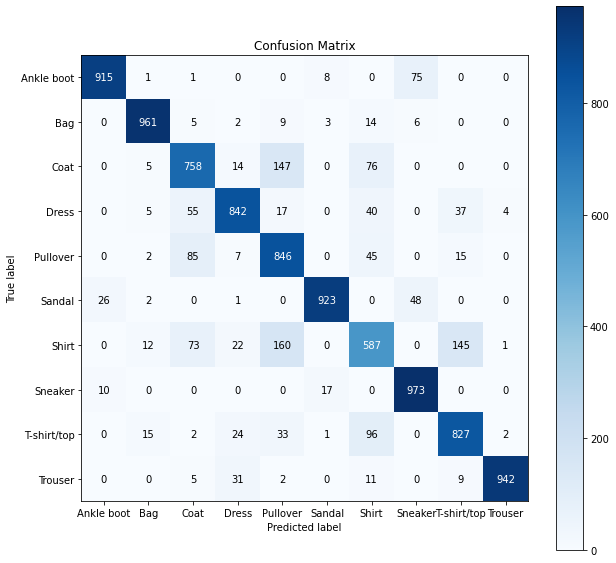

In [ ]:
test_acc,test_pred=test_model()
ytest_pred=[class_names[k] for k in test_pred]
ytest=[class_names[k]  for k in y_test]
confusion_mat=skplt.metrics.plot_confusion_matrix(ytest,ytest_pred,figsize=(10,10))

#**Run wandb sweep**

In [ ]:
#sweep_id = wandb.sweep(sweep_config,entity='sanjeevrs',project='assignment1')       #Uncomment for wandb

Create sweep with ID: vj86die6
Sweep URL: https://wandb.ai/sanjeevrs/assignment1/sweeps/vj86die6


In [ ]:
#wandb.agent(sweep_id, Train)            #Uncomment for wandb

wandb: Agent Starting Run: cjh4yko0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.01
wandb: 	hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	size: 32
wandb: 	wt_decay: 0.005
wandb: Currently logged in as: sanjeevrs (use `wandb login --relogin` to force relogin)


epochs,5
learning rate,0.01
no of hidden layers,3
layer size,32
batch size,32
optimizer,adam
val loss,0.4831
validation accuracy,0.8203
_runtime,112
_timestamp,1615572495
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7dhaoi9l with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.01
wandb: 	hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	size: 64
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.01
no of hidden layers,3
layer size,64
batch size,32
optimizer,adam
val loss,0.40092
validation accuracy,0.8566
_runtime,229
_timestamp,1615572743
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: yzx6e0te with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.01
wandb: 	hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size: 32
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.01
no of hidden layers,3
layer size,32
batch size,32
optimizer,rmsprop
val loss,0.47156
validation accuracy,0.8372
_runtime,108
_timestamp,1615572861
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: cb1827bc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.01
wandb: 	hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size: 64
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.01
no of hidden layers,3
layer size,64
batch size,32
optimizer,rmsprop
val loss,0.45066
validation accuracy,0.8364
_runtime,217
_timestamp,1615573088
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: b1g8bb3x with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.01
wandb: 	hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	size: 32
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.01
no of hidden layers,4
layer size,32
batch size,32
optimizer,adam
val loss,0.65438
validation accuracy,0.7325
_runtime,134
_timestamp,1615573232
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: h3ba1fme with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.01
wandb: 	hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	size: 64
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.01
no of hidden layers,4
layer size,64
batch size,32
optimizer,adam
val loss,0.45435
validation accuracy,0.8434
_runtime,256
_timestamp,1615573497
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: tkbdtw0r with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.01
wandb: 	hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	size: 32
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.01
no of hidden layers,4
layer size,32
batch size,32
optimizer,rmsprop
val loss,0.48853
validation accuracy,0.8227
_runtime,130
_timestamp,1615573637
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: iyhocdlt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.01
wandb: 	hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	size: 64
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.01
no of hidden layers,4
layer size,64
batch size,32
optimizer,rmsprop
val loss,0.43672
validation accuracy,0.8513
_runtime,243
_timestamp,1615573890
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 2yu55v33 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.001
wandb: 	hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	size: 32
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.001
no of hidden layers,3
layer size,32
batch size,32
optimizer,adam
val loss,1.03582
validation accuracy,0.6136
_runtime,112
_timestamp,1615574014
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: t98bkeem with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.001
wandb: 	hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	size: 64
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.001
no of hidden layers,3
layer size,64
batch size,32
optimizer,adam
val loss,0.67174
validation accuracy,0.7728
_runtime,226
_timestamp,1615574251
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: oi46oxkq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.001
wandb: 	hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size: 32
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.001
no of hidden layers,3
layer size,32
batch size,32
optimizer,rmsprop
val loss,0.67867
validation accuracy,0.734
_runtime,110
_timestamp,1615574371
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: c9486sro with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.001
wandb: 	hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size: 64
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.001
no of hidden layers,3
layer size,64
batch size,32
optimizer,rmsprop
val loss,0.43413
validation accuracy,0.8466
_runtime,179
_timestamp,1615574565
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


502 response executing GraphQL.
<!DOCTYPE html>
<html lang=en>
  <meta charset=utf-8>
  <meta name=viewport content="initial-scale=1, minimum-scale=1, width=device-width">
  <title>Error 502 (Server Error)!!1</title>
  <style>
    *{margin:0;padding:0}html,code{font:15px/22px arial,sans-serif}html{background:#fff;color:#222;padding:15px}body{margin:7% auto 0;max-width:390px;min-height:180px;padding:30px 0 15px}* > body{background:url(//www.google.com/images/errors/robot.png) 100% 5px no-repeat;padding-right:205px}p{margin:11px 0 22px;overflow:hidden}ins{color:#777;text-decoration:none}a img{border:0}@media screen and (max-width:772px){body{background:none;margin-top:0;max-width:none;padding-right:0}}#logo{background:url(//www.google.com/images/branding/googlelogo/1x/googlelogo_color_150x54dp.png) no-repeat;margin-left:-5px}@media only screen and (min-resolution:192dpi){#logo{background:url(//www.google.com/images/branding/googlelogo/2x/googlelogo_color_150x54dp.png) no-repeat 0% 0%/100

epochs,5
learning rate,0.001
no of hidden layers,4
layer size,32
batch size,32
optimizer,adam
val loss,1.20069
validation accuracy,0.5348
_runtime,136
_timestamp,1615574716
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: mmpzrlim with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.001
wandb: 	hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	size: 64
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.001
no of hidden layers,4
layer size,64
batch size,32
optimizer,adam
val loss,0.8101
validation accuracy,0.6384
_runtime,217
_timestamp,1615574947
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: qtjl22lx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.001
wandb: 	hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	size: 32
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.001
no of hidden layers,4
layer size,32
batch size,32
optimizer,rmsprop
val loss,0.68928
validation accuracy,0.7239
_runtime,126
_timestamp,1615575087
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: vn5zfbkn with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.001
wandb: 	hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	size: 64
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.001
no of hidden layers,4
layer size,64
batch size,32
optimizer,rmsprop
val loss,0.5929
validation accuracy,0.7952
_runtime,200
_timestamp,1615575302
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: inrf73s4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.01
wandb: 	hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	size: 32
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.01
no of hidden layers,3
layer size,32
batch size,32
optimizer,adam
val loss,0.5935
validation accuracy,0.7704
_runtime,114
_timestamp,1615575430
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: i1eaujiz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.01
wandb: 	hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	size: 64
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.01
no of hidden layers,3
layer size,64
batch size,32
optimizer,adam
val loss,0.53276
validation accuracy,0.8082
_runtime,201
_timestamp,1615575646
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 1egrp3d5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.01
wandb: 	hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size: 32
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.01
no of hidden layers,3
layer size,32
batch size,32
optimizer,rmsprop
val loss,0.53774
validation accuracy,0.8161
_runtime,112
_timestamp,1615575772
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ncctuyx3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.01
wandb: 	hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size: 64
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.01
no of hidden layers,3
layer size,64
batch size,32
optimizer,rmsprop
val loss,0.55923
validation accuracy,0.7997
_runtime,183
_timestamp,1615575969
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 3hbcrk1m with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.01
wandb: 	hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	size: 32
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.01
no of hidden layers,4
layer size,32
batch size,32
optimizer,adam
val loss,0.58137
validation accuracy,0.7949
_runtime,137
_timestamp,1615576121
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: revzigp5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.01
wandb: 	hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	size: 64
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.01
no of hidden layers,4
layer size,64
batch size,32
optimizer,adam
val loss,0.5221
validation accuracy,0.8159
_runtime,221
_timestamp,1615576356
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: mgc72oa5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.01
wandb: 	hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	size: 32
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.01
no of hidden layers,4
layer size,32
batch size,32
optimizer,rmsprop
val loss,0.56592
validation accuracy,0.8146
_runtime,133
_timestamp,1615576504
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: ppyoixyh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.01
wandb: 	hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	size: 64
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.01
no of hidden layers,4
layer size,64
batch size,32
optimizer,rmsprop
val loss,0.59384
validation accuracy,0.789
_runtime,212
_timestamp,1615576730
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: klzyump6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.001
wandb: 	hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	size: 32
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.001
no of hidden layers,3
layer size,32
batch size,32
optimizer,adam
val loss,0.88001
validation accuracy,0.5624
_runtime,115
_timestamp,1615576860
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: nw1vym0d with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.001
wandb: 	hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	size: 64
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.001
no of hidden layers,3
layer size,64
batch size,32
optimizer,adam
val loss,0.54904
validation accuracy,0.7614
_runtime,199
_timestamp,1615577073
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: qlrx0gnz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.001
wandb: 	hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size: 32
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.001
no of hidden layers,3
layer size,32
batch size,32
optimizer,rmsprop
val loss,0.43547
validation accuracy,0.8499
_runtime,111
_timestamp,1615577199
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: b1pz2qhd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.001
wandb: 	hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size: 64
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.001
no of hidden layers,3
layer size,64
batch size,32
optimizer,rmsprop
val loss,0.37893
validation accuracy,0.8676
_runtime,185
_timestamp,1615577398
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: s7x5n7ga with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.001
wandb: 	hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	size: 32
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.001
no of hidden layers,4
layer size,32
batch size,32
optimizer,adam
val loss,0.90225
validation accuracy,0.6421
_runtime,137
_timestamp,1615577549
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 6g28zovt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.001
wandb: 	hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	size: 64
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.001
no of hidden layers,4
layer size,64
batch size,32
optimizer,adam
val loss,2.30697
validation accuracy,0.1008
_runtime,222
_timestamp,1615577786
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: zkw2hjo8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.001
wandb: 	hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	size: 32
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.001
no of hidden layers,4
layer size,32
batch size,32
optimizer,rmsprop
val loss,0.69239
validation accuracy,0.7217
_runtime,134
_timestamp,1615577934
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Agent Starting Run: 9za5ecu3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.001
wandb: 	hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	size: 64
wandb: 	wt_decay: 0.005


epochs,5
learning rate,0.001
no of hidden layers,4
layer size,64
batch size,32
optimizer,rmsprop
val loss,0.47847
validation accuracy,0.8319
_runtime,213
_timestamp,1615578161
_step,0


epochs,▁
learning rate,▁
no of hidden layers,▁
layer size,▁
batch size,▁
val loss,▁
validation accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
